# All plots for ANC paper


This notebook produces all the plots that we include in the ANC paper

In [1]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
plt.style.use('science')

# Section 2

In [244]:
from gwpy.timeseries import TimeSeries
from matplotlib import pyplot as plt
import scienceplots
import pandas as pd 
import numpy as np 

plt.style.use('science')

#Example from https://gwpy.github.io/docs/latest/spectrum/

#Channels that we will plot the ASD of
L1_string = 'L1:DCS-CALIB_STRAIN_C01_AR'
H1_string = 'H1:DCS-CALIB_STRAIN_C01_AR'


#Setelct some times from the O3 segments
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)#10 mins later


#Get the data
print("get the data")
gwdata_L1   = TimeSeries.get(L1_string,start=t0, end=t1,host='losc-nds.ligo.org')
spectrum_L1 = gwdata_L1.asd(8, 4) #Welch method. Also used in GWPy example

print("get data 2")
gwdata_H1   = TimeSeries.get(H1_string,start=t0, end=t1,host='losc-nds.ligo.org')
spectrum_H1 = gwdata_H1.asd(8, 4) #Welch method. Also used in GWPy example


freqs_L1 = np.arange(len(spectrum_L1))*spectrum_L1.df
asd_L1 = np.array(spectrum_L1)

freqs_H1 = np.arange(len(spectrum_H1))*spectrum_H1.df
asd_H1 = np.array(spectrum_H1)

get the data
get data 2


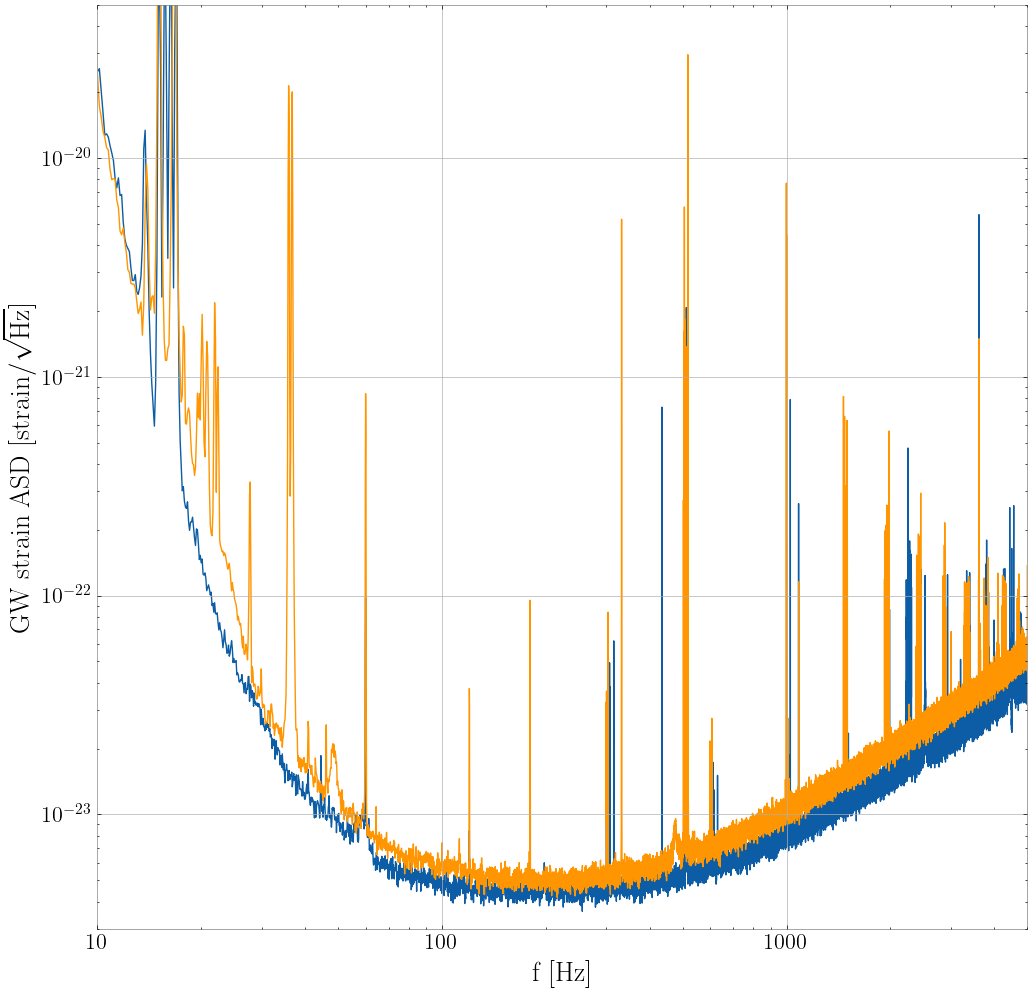

In [245]:



from matplotlib import pyplot as plt
import scienceplots
import glob
import numpy as np
plt.style.use('science')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

ax.plot(freqs_L1,asd_L1,c="C0")
ax.plot(freqs_H1,asd_H1,c="C2")



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.set_ylim(3e-24, 5e-20)


fs = 20
ax.set_ylabel(r'GW strain ASD [strain$/\sqrt{\mathrm{Hz}}$]',fontsize=fs)
ax.set_xlabel(r'f [Hz]',fontsize=fs)


ax.axes.tick_params(axis="both", labelsize=fs-4)



plt.savefig('../../data/manuscript_images/sensitivity_sq2.png',bbox_inches='tight',dpi=300)



#### Coherence plots


NOTE. This plot below is now obselete.

For the manuscript we use different (private) data sources. 

See the script at `/home/tom.kimpson/ANC` on `ssh.ligo.org`


In [6]:
import pandas as pd 
from gwpy.timeseries import TimeSeries
L1_string = 'L1:DCS-CALIB_STRAIN_C01_AR' #strain channel

pem_channels = ['L1:PEM-CS_MAINSMON_EBAY_1_DQ',   
                 'L1:PEM-CS_MAINSMON_EBAY_2_DQ',
                 'L1:PEM-CS_MAINSMON_EBAY_3_DQ',
                 'L1:PEM-CS_MIC_LVEA_INPUTOPTICS_DQ',
                 'L1:PEM-EY_ACC_BEAMTUBE_MAN_Y_DQ',
                 'L1:PEM-EY_MAINSMON_EBAY_1_DQ',
                 'L1:PEM-EY_MIC_VEA_PLUSY_DQ',
                 'L1:PEM-EY_VAULT_MAG_LEMI_X_DQ',
                 'L1:PEM-EY_VAULT_MAG_LEMI_Y_DQ'
]


#Select some times from the O3 segments
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)# 10 mins later


#Load the strain data
hoft   = TimeSeries.get(L1_string,start=t0, end=t1,host='losc-nds.ligo.org')


0 L1:PEM-CS_MAINSMON_EBAY_1_DQ


/Users/t1/miniconda3/envs/LIGO_ANC/lib/python3.9/site-packages/gwpy/signal/spectral/_scipy.py:223: UserWarning: Sampling frequencies are unequal. Higher frequency series will be downsampled before coherence is calculated
  warnings.warn("Sampling frequencies are unequal. Higher "


1 L1:PEM-CS_MAINSMON_EBAY_2_DQ
2 L1:PEM-CS_MAINSMON_EBAY_3_DQ
3 L1:PEM-CS_MIC_LVEA_INPUTOPTICS_DQ
4 L1:PEM-EY_ACC_BEAMTUBE_MAN_Y_DQ
5 L1:PEM-EY_MAINSMON_EBAY_1_DQ
6 L1:PEM-EY_MIC_VEA_PLUSY_DQ
7 L1:PEM-EY_VAULT_MAG_LEMI_X_DQ
8 L1:PEM-EY_VAULT_MAG_LEMI_Y_DQ


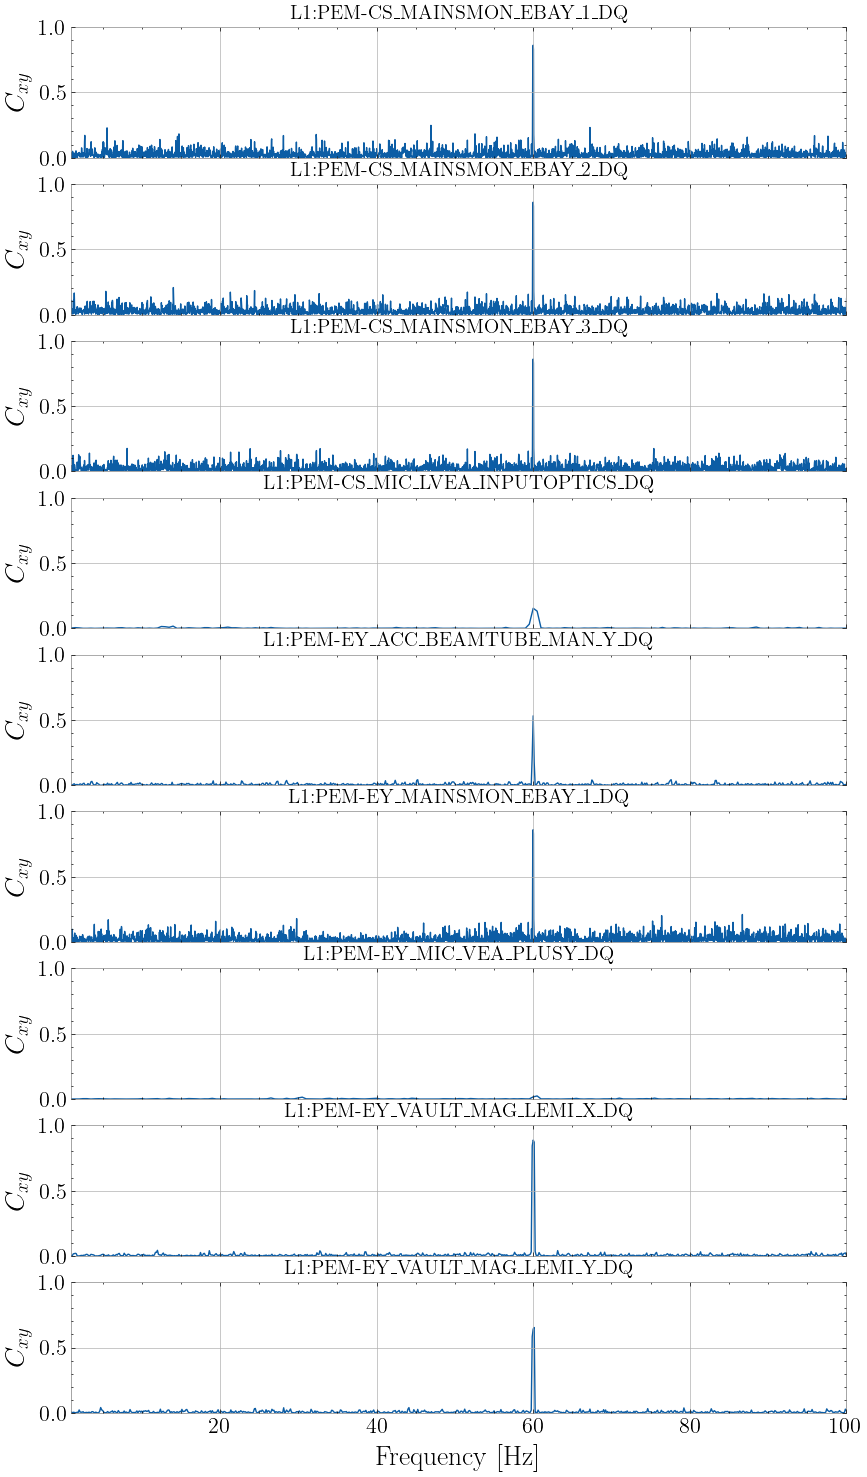

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

num_pem_channels = len(pem_channels)
fig, axes = plt.subplots(nrows=num_pem_channels, ncols=1, figsize=(10,18),sharex=True)

#Load the pem data and get the coherence w.r.t the strain channel

fs = 20
for i in range(num_pem_channels):


    pem = pem_channels[i]
    print(i, pem)
    #acc   = TimeSeries.get(pem,start=t0, end=t1,host='losc-nds.ligo.org')

    #Load the pem channel from disk
    acc = TimeSeries.read(f'../../data/pem_channels/{pem}.txt')

    
    #Coherence
    coh = hoft.coherence(acc, fftlength=2, overlap=1)


    coherence_frequencies = np.array(coh.frequencies)
    coherence_values = np.array(coh)


    ax = axes[i]

    ax.plot(coherence_frequencies,coherence_values)


    ax.set_xlim(1, 100)
    ax.set_ylim(0, 1)

    ax.set_ylabel(r'$C_{xy}$',fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    ax.set_title(pem)


    #ax.set_yscale('log')


axes[-1].set_xlabel(r'Frequency [Hz]',fontsize=fs)
fname='stacked_coherence_plot'
plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)



### Cascade plot 

Modified version of https://git.ligo.org/hannah.middleton/anc/-/blob/master/code/plottingScripts/powerCascade/2dPowerCascade.py


In [98]:
#First lets find some times with uninterrupted segments of data

from gwpy.detector import ChannelList, Channel
server = 'losc-nds.ligo.org'  #-- GWOSC NDS2 server name

chanlist = ChannelList.query_nds2('*', host='losc-nds.ligo.org' )
auxlist = ['H1:PEM-CS_MAINSMON_EBAY_1_DQ']
day = 60*60*24
t0  = 1264316116 #time of GW200129_065458

t0 = 1238166018 #start time of O3a
end_time = 1253977218 #end time of O3a


batchSize = 64*5
numplots = 210
print(batchSize*numplots)


available = chanlist.query_nds2_availability(auxlist, t0, end_time, host=server)


segments = available['H1:PEM-CS_MAINSMON_EBAY_1_DQ']
for i in range(len(segments)):
   segment_length = segments[i][1]-segments[i][0]
   if segment_length > batchSize*numplots:
       print(i,segments[i][0],segments[i][1],segments[i][1]-segments[i][0])
    

67200
144 1241569755 1241680362 110607
146 1241739102 1241808777 69675
179 1242300497 1242399908 99411
191 1242681900 1242773530 91630
192 1242773673 1242867876 94203
211 1243393026 1243509653 116627
233 1243988023 1244076204 88181
234 1244082982 1244221152 138170
254 1244593947 1244669435 75488
284 1245396780 1245489278 92498
300 1245967228 1246040115 72887
314 1246452223 1246549997 97774
315 1246561822 1246659651 97829
328 1246967851 1247036503 68652
329 1247042149 1247131971 89822
349 1247658929 1247749610 90681
372 1248357903 1248428214 70311
388 1249000654 1249077952 77298
407 1249546713 1249662942 116229
408 1249663748 1249742752 79004
413 1250031072 1250125353 94281
427 1250551601 1250628515 76914
436 1250980674 1251057621 76947
473 1252299925 1252411953 112028
491 1252898302 1252970115 71813
495 1253085510 1253187699 102189
510 1253717892 1253809339 91447
520 1253892200 1253966059 73859


In [100]:
138170/batchSize

431.78125

In [44]:
#First lets find some times with uninterrupted segments of data

from gwpy.detector import ChannelList, Channel
server = 'losc-nds.ligo.org'  #-- GWOSC NDS2 server name

chanlist = ChannelList.query_nds2('*', host='losc-nds.ligo.org' )
auxlist = ['H1:PEM-CS_MAINSMON_EBAY_1_DQ']
day = 60*60*24
t0  = 1264316116 #time of GW200129_065458
available = chanlist.query_nds2_availability(auxlist, t0, t0+30*day, host=server)
#for chan in auxlist:
   # print(chan, 'is available at GPS:', available[chan])


segments = available['H1:PEM-CS_MAINSMON_EBAY_1_DQ']
for i in range(len(segments)):
    print(i,segments[i][0],segments[i][1],segments[i][1]-segments[i][0])
    

0 1264316116 1264370267 54151
1 1264392987 1264403179 10192
2 1264409744 1264436140 26396
3 1264442607 1264452560 9953
4 1264454643 1264457418 2775
5 1264462727 1264469840 7113
6 1264477009 1264521216 44207
7 1264521591 1264526137 4546
8 1264531957 1264535208 3251
9 1264542917 1264568467 25550
10 1264568681 1264571417 2736
11 1264572039 1264591699 19660
12 1264597197 1264703538 106341
13 1264703820 1264734208 30388
14 1264734278 1264784410 50132
15 1264784617 1264791613 6996
16 1264794808 1264809614 14806
17 1264809643 1264866326 56683
18 1264897151 1264904061 6910
19 1264908177 1264934798 26621
20 1264938865 1264947697 8832
21 1264950071 1264951103 1032
22 1264951532 1264982347 30815
23 1264988059 1265045316 57257
24 1265045418 1265047500 2082
25 1265054157 1265060484 6327
26 1265064926 1265067935 3009
27 1265080011 1265098299 18288
28 1265098394 1265130933 32539
29 1265138874 1265150428 11554
30 1265161162 1265161286 124
31 1265175537 1265212294 36757
32 1265218952 1265242703 23751
3

In [133]:
#Get the data
referenceChannelName = 'H1:PEM-CS_MAINSMON_EBAY_1_DQ'
start_time = 1265852907
start_time_o3 = 1244082982 
#noToPlot = 210
noToPlot = 430

end_time = start_time_o3 + batchSize*noToPlot
reference   = TimeSeries.get(referenceChannelName,start=start_time_o3, end=end_time,host='losc-nds.ligo.org')


KeyboardInterrupt: 

In [103]:
#Save it 
reference.write(f'../../data/cascade_H1_file_o3_large.txt')


In [104]:
#Load it again
nr = TimeSeries.read(f'../../data/cascade_H1_file_o3.txt')

In [105]:
#Chop it up into batches and save to disk
reference_np = np.array(reference)
times_np = np.array(reference.times)

split_arrays = np.split(reference_np,noToPlot)
split_array_times = np.split(times_np,noToPlot)

In [106]:
for i in range(len(split_arrays)):
    print(i)
    ts_i = TimeSeries(split_arrays[i], unit=reference.unit,sample_rate=reference.sample_rate,times=split_array_times[i])
    ts_i.write(f'../../data/cascade_H1_O3/H1_{i}.txt')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209


In [107]:
from gwpy.timeseries import TimeSeries
import matplotlib .pyplot as plt 
import matplotlib as mpl

def read_and_plot(file_path):
    #print ("Reading: ", file_path)
    reference   = TimeSeries.read(file_path)

    #Get the ASD
    refASD = reference.asd()
   
    #Some parameter defns
    fLimLow  = 59.5
    fLimHigh = 60.5


    fstart = refASD.f0.value
    fend = len(refASD.value)*refASD.df.value
    fstep = refASD.df.value
   
    fs = np.arange(fstart,fend,fstep)

    indexLow  = int( fLimLow / fstep )+1
    indexHigh = int( fLimHigh/ fstep )

    val = refASD.value
    return fs[indexLow:indexHigh], val[indexLow:indexHigh]



def offset(myFig,myAx,n=1):
    #shift = yOff / myFig.dpi
    #dx, dy = 0., shift

    shift = 0.02
    dx, dy = 0., shift
    return (myAx.transData + mpl.transforms.ScaledTranslation(dx,n*dy,myFig.dpi_scale_trans)), shift



In [108]:
import re

#natural sorting e.g. https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


The peak of the ASD varies from 59.96875 to 60.053125 Hz, with an average value of 60.00400297619048 Hz
The FWHM varies from 5.293773141356687 to 29.37747080651693 mHz, with an average value of 10.748538587464264 mHz


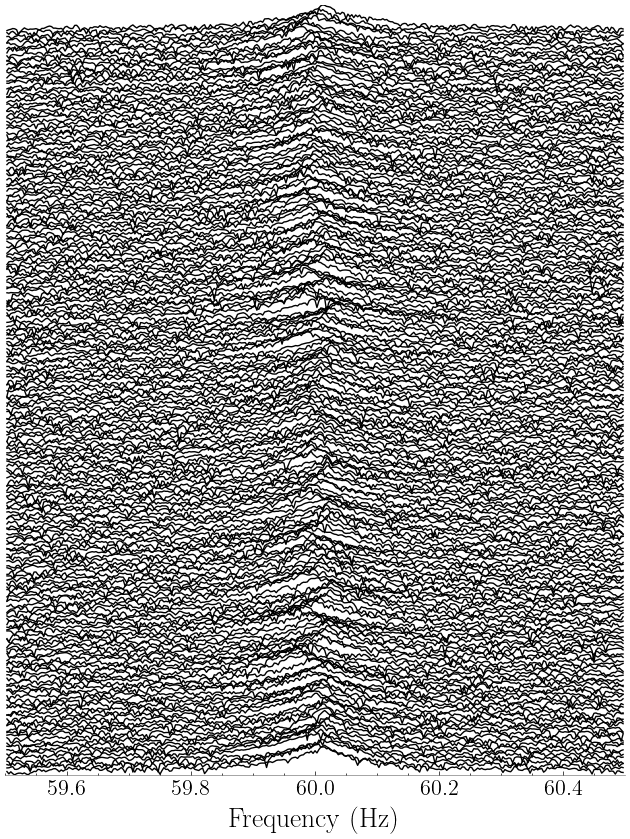

In [134]:
import glob
import scienceplots
from scipy.signal import peak_widths
from scipy.interpolate import interp1d



def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)






plt.style.use('science')

list_of_cascade_files = glob.glob('../../data/cascade_H1_O3/*')
list_of_cascade_files.sort(key=natural_keys)

#setup the figure
fig, ax = plt.subplots(figsize=(8,10))

#How many batches to plot?
num_to_plot = len(list_of_cascade_files)

ymin = +1e3
ymax = -1e3
peaks = np.zeros(num_to_plot)
FWHMs = np.zeros(num_to_plot)
for i in range(num_to_plot):

    #Load the data
    f = list_of_cascade_files[i]
    xs, ys = read_and_plot(f)
    log10ys = np.log10(ys)

    #Shift, log and plot it
    shift= 0.6
    yplot = log10ys+shift*i
  
    
    #Surface some numbers
    idx = np.argmax(ys) #index of maximum
    peaks[i] = xs[idx]
    
    #https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
    results = peak_widths(ys, [idx], rel_height=0.5)

    
 
    df = np.diff(xs)[0] #this is the same spacing between every sample
    width_in_samples = results[0][0]
    width_in_hz = width_in_samples*df


    FWHMs[i] = width_in_hz*1e3 
   
    #Plot it 
    ax.plot(xs,yplot,color='k')
    #trans, shift = offset(fig,ax,i)
    #zInd = num_to_plot - i
    #ax.plot(xs,log10ys+shift*i,color='k',linewidth=0.5, zorder = zInd)

   

    if min(yplot) < ymin:
        ymin = min(yplot)
    if max(yplot) > ymax:
        ymax = max(yplot)

    #ax.plot(xs,log10ys+shift*i,color='k',linewidth=0.5, transform = trans)



#Config figure 

ax.set_xlim(59.5, 60.5)
fs=20
ax.set_xlabel('Frequency (Hz)',fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.grid(False)

for side in ["top", "right", "left"]:
    ax.spines[side].set_visible(False)

plt.tick_params(axis='x', which='both',top=False)
ax.set_yticks([])
ax.set_ylim(ymin, ymax)

plt.savefig('../../data/images/new_cascade_O3_new',bbox_inches='tight',dpi=300)



print (f"The peak of the ASD varies from {np.min(peaks)} to {np.max(peaks)} Hz, with an average value of {np.mean(peaks)} Hz")

print (f"The FWHM varies from {np.min(FWHMs)} to {np.max(FWHMs)} mHz, with an average value of {np.mean(FWHMs)} mHz")
 


In [137]:
(60.00400297619048 - 59.96875)*1e3


(60.00400297619048 - 60.053125)*1e3



-49.122023809523796

In [114]:
x = np.linspace(0, 6 * np.pi, 1000)
x = np.sin(x) + 0.6 * np.sin(2.6 * x)

In [125]:
def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

FWHMs

array([59.51471022, 59.52466289, 59.51263691, ..., 59.51971724,
       59.51344458, 59.51700982])

#Firs

In [113]:
peaks 
#FWHMs = []

[16279.86120662953,
 13527.403709393233,
 18528.404990108458,
 23902.37160477531,
 15242.52463553138,
 15767.380827234529,
 19205.75894452465,
 22050.582707015266,
 22372.10480631419,
 21253.88012359745,
 23575.67966580356,
 15105.653121283473,
 19733.323488522215,
 17140.597714907835,
 22187.06648796841,
 19531.831077370214,
 12629.720539923193,
 16029.346322993442,
 19310.777087717706,
 18024.307028579566,
 22072.673840632426,
 15445.902028882589,
 17779.50384375851,
 20427.28384787763,
 17816.6690179557,
 13068.584462066734,
 16317.409278024197,
 14458.652349624746,
 19099.668315785595,
 19743.63402463328,
 21644.598855933862,
 19668.437282048624,
 21365.847071238913,
 22324.665442403,
 19787.88793988651,
 18995.755261959155,
 17872.515731098898,
 19177.903832015676,
 12760.267236100115,
 23003.12544980675,
 14464.765010573969,
 17211.806185888934,
 18404.642027509377,
 23132.560152649985,
 23784.90512893432,
 14741.04310147899,
 22533.401072827895,
 21943.235579840835,
 15384.78055

## Section 4B



### Fourier response of data before/after filtering 

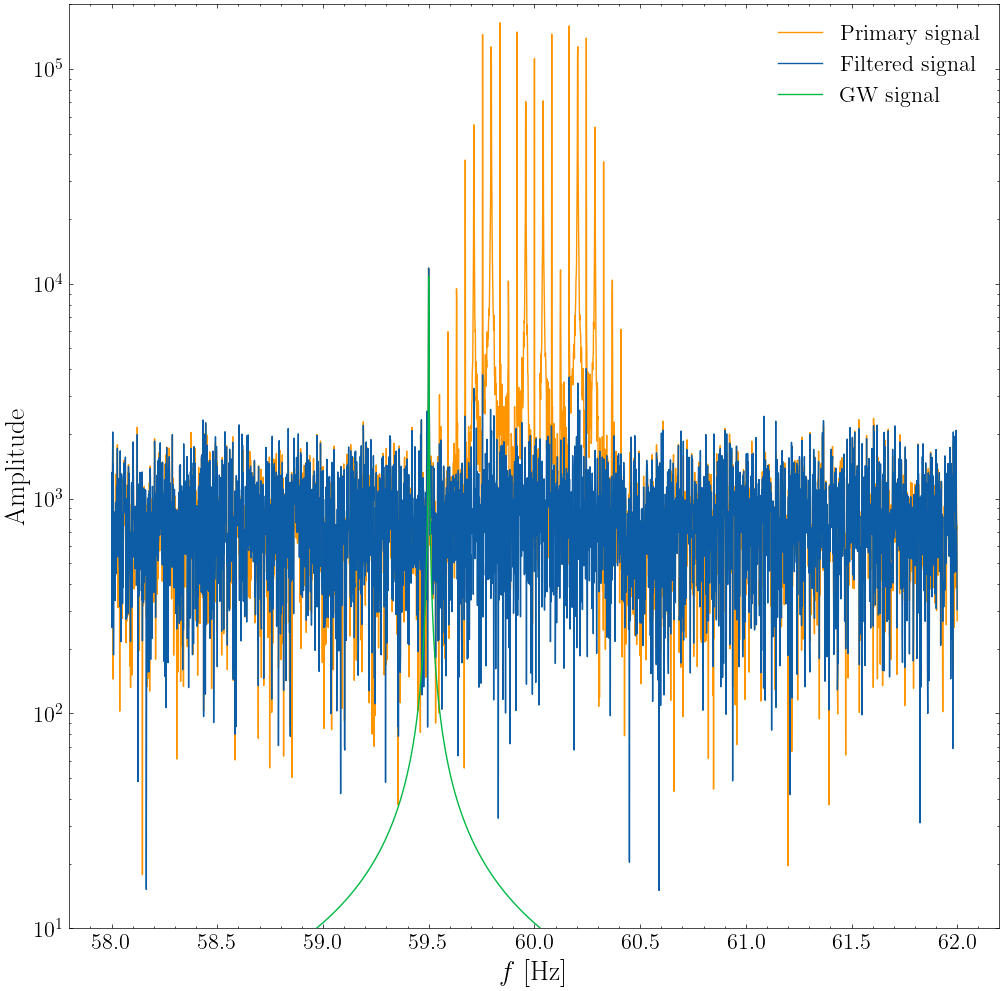

In [16]:
#Load the data
data = loadmat("../../data/fig_spectrum.mat")

C = data['C'].flatten()
Q = data['Q'].flatten()
S = data['S'].flatten()
w = data['w'].flatten() #frequencies



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

ax.plot(w,S,label="Primary signal",c='C2')
ax.plot(w,C,label="Filtered signal",c='C0')
ax.plot(w,Q,label="GW signal",c='C1')

# ax.plot(w,Q,label="GW signal")
# ax.plot(w,S,label="Primary signal")
# ax.plot(w,C,label="Filtered signal")



fs = 20
ax.set_ylabel(r'Amplitude',fontsize=fs)
ax.set_xlabel(r'$f$ [Hz]',fontsize=fs)


ax.set_yscale('log')
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)

ax.set_ylim(1e1,2e5)

plt.savefig('../../data/images/spectrum',bbox_inches='tight',dpi=300)
plt.show()




### 2D Viterbi tracking plots 

In [87]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes





def mean_squared_error(data_true,data_predict):
    MSE = np.square(np.subtract(data_true,data_predict)).mean()
    return MSE





def load_data(path):

    data = loadmat(path)


    viterbi_with_pem = data['Y'] #Viterbi input matrix with PEM and GW. (131, 50)
    viterbi_without_pem = data['y'] # Viterbi input matrix with PEM cancelled #(131, 50)
    f = data['w0'].flatten()
    t = data['time'].flatten()


    GW_freq_true  = data['fq'].flatten()
    GW_freq_estim  = data['fhat_RLS'].flatten() #estimated GW frequency (with Viterbi) after the ANC

    return viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true,GW_freq_estim






def plot_2d(xbefore,xafter,f,t,GW_f_true1,GW_f_estim1,GW_f_true2,GW_f_estim2,vmin,vmax,fname=None,reverse_ordering=False,cmap='viridis'):

    #Plot figure
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,9),sharey=True)


    pos1 = ax1.imshow(xbefore, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200)
    pos2 = ax2.imshow(xafter, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200)

    
    lw = 2.0
    ls = '--'

    # manually reverse the ordering since it should go the other way around according to Sofia
    if reverse_ordering:
        GW_f_true1 = GW_f_true1[::-1] 
        GW_f_estim1 = GW_f_estim1[::-1] 


        GW_f_true2 = GW_f_true2[::-1] 
        GW_f_estim2 = GW_f_estim2[::-1] 



    #Plot the true GW frequencies on LHS
    ax1.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax1.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax1.scatter(GW_f_true1,t,c='C2')
    ax1.scatter(GW_f_true2,t,c='C1')

    #Plot true GW freqs on RHS
    ax2.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax2.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax2.scatter(GW_f_true1,t,c='C2')
    ax2.scatter(GW_f_true2,t,c='C1')


    #Plot estimates on RHS    
    ax2.plot(GW_f_estim1,t,c='C3',linewidth=lw,linestyle='dashed')
    ax2.plot(GW_f_estim2,t,c='y',linewidth=lw,linestyle='dashed')


    #Surface some error estimates
    MSE_low_noise = mean_squared_error(GW_f_true1,GW_f_estim1)
    MSE_high_noise = mean_squared_error(GW_f_true2,GW_f_estim2)

    print("Mean squared error in the frequency is:")
    print('MSE, low noise:', MSE_low_noise)
    print('MSe, high noise:', MSE_high_noise)






    fs = 20
    ax1.set_ylabel(r'Time [s]',fontsize=fs)
    ax1.set_xlabel(r'$f$ [Hz]',fontsize=fs)
    ax2.set_xlabel(r'$f$ [Hz]',fontsize=fs)

    ax1.axes.tick_params(axis="both", labelsize=fs-4)
    ax2.axes.tick_params(axis="both", labelsize=fs-4)


    plt.subplots_adjust(wspace=0.01)
    #ax2.spines['left'].set_color('white')


    axins = inset_axes(ax2, width = "5%", height = "100%", loc = 'lower left',
                       bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax2.transAxes,
                       borderpad = 0)
    fig.colorbar(pos2, cax = axins)

    axins.axes.tick_params(axis="both", labelsize=fs-4)
    axins.axes.set_ylabel(r'$ \left |\mathcal{F} \left[ x(t)\right] \right|^2$',rotation=0,fontsize=fs,labelpad=15)


    ax1.set_xlim(f[0],f[-1])
    ax1.set_ylim(t[0],t[-1])
    ax2.set_xlim(f[0],f[-1])
    ax2.set_ylim(t[0],t[-1])


    if fname is not None:
       plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)




    plt.show()








Mean squared error in the frequency is:
MSE, low noise: 0.0014117100877654501
MSe, high noise: 0.22380607056663052


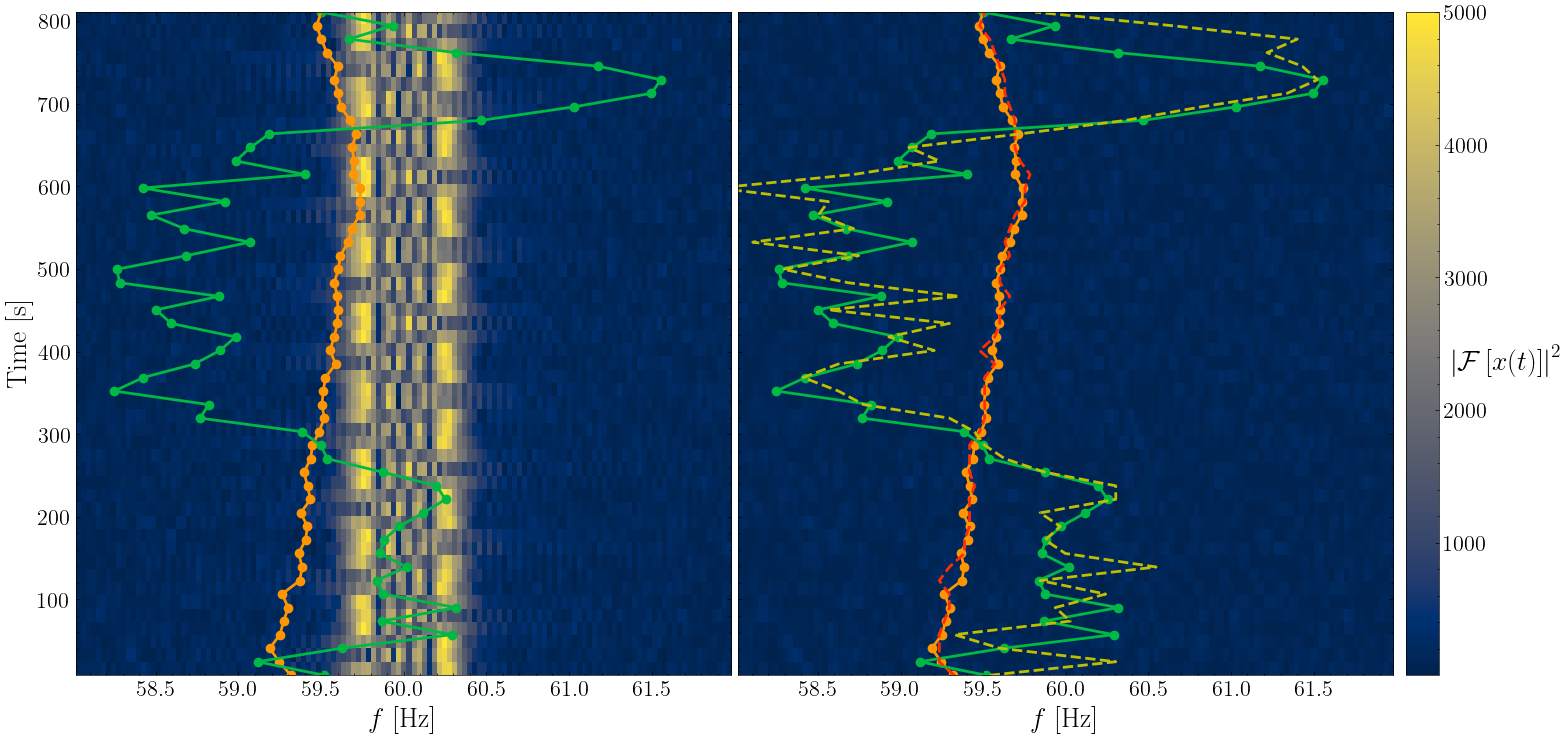

In [88]:
path1 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_1.mat"
viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true1,GW_freq_estim1 = load_data(path1)


path2 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_2.mat"
_,_,_,_,GW_freq_true2,GW_freq_estim2 = load_data(path2)



##Low contrast
cbar_lower_limit = 1
cbar_upper_limit = 5000
plot_2d(viterbi_with_pem.T,viterbi_without_pem.T,f,t,GW_freq_true1,GW_freq_estim1,GW_freq_true2,GW_freq_estim2,cbar_lower_limit,cbar_upper_limit,fname='viterbi_tracking_canonical',reverse_ordering=True,cmap='cividis')

# Section 4C

In this section we vary the power line parameters, for a single reference channel, and generate some ROC curves 

$ \Delta f = 0.0 \, , \gamma = 0.001$ Computed AUC using sklearn.metrics.auc: 0.67765
$\Delta f = 0.0 \, ,  \gamma = 0.01$ Computed AUC using sklearn.metrics.auc: 0.65315
$ \Delta f = 0.0 \, , \gamma = 0.1$ Computed AUC using sklearn.metrics.auc: 0.5529499999999999
$ \gamma = 0.02 \, , \Delta f = 0.25$ Computed AUC using sklearn.metrics.auc: 0.6231000000000001
$ \gamma = 0.02 \, ,  \Delta f = 0.5$ Computed AUC using sklearn.metrics.auc: 0.5787
$ \gamma = 0.02 \, , \Delta f = 1.0$ Computed AUC using sklearn.metrics.auc: 0.58465


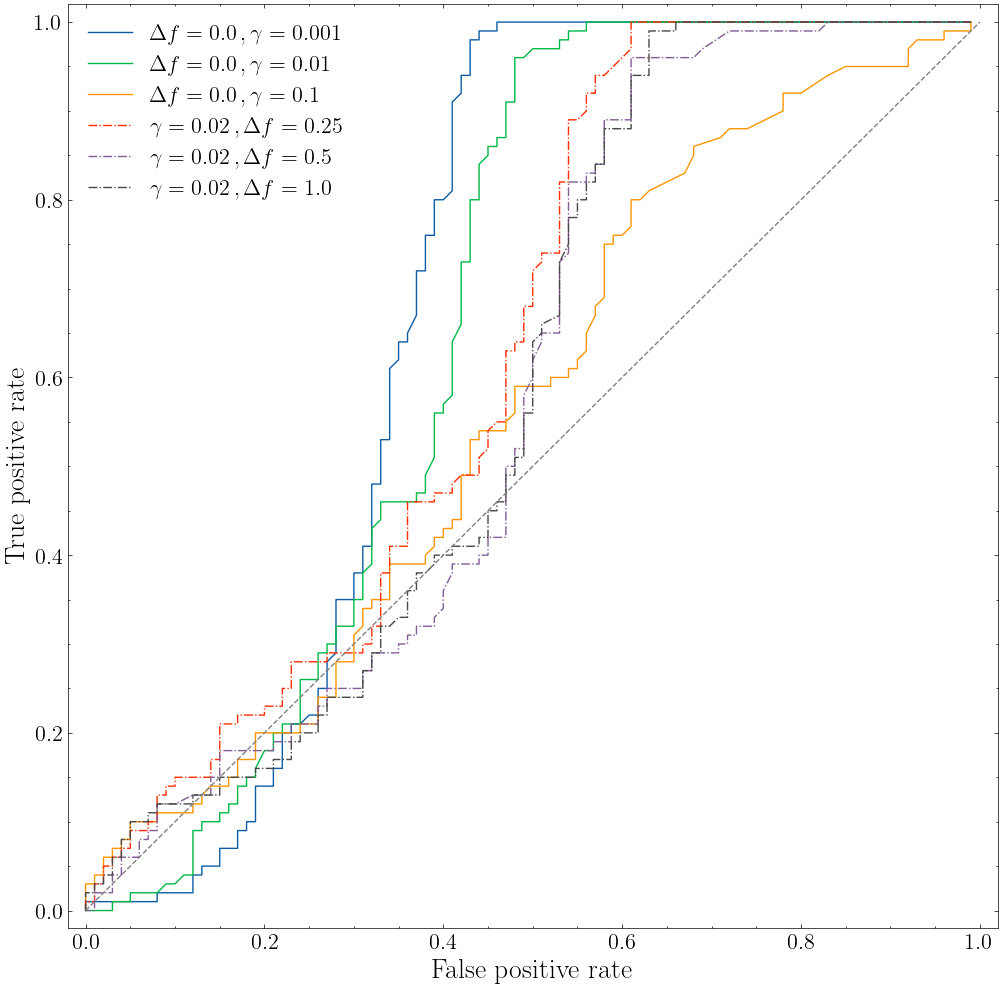

In [243]:

from scipy.io import loadmat
import numpy as np 


from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob 
import sys
from sklearn.metrics import auc

plt.style.use('science')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)




path1 = "../../data/roc_sec4_1.mat"
path2 = "../../data/roc_sec4_2.mat"

labels1 = [r'$ \Delta f = 0.0 \, , \gamma = 0.001$', r'$\Delta f = 0.0 \, ,  \gamma = 0.01$',r'$ \Delta f = 0.0 \, , \gamma = 0.1$']
labels2 = [r'$ \gamma = 0.02 \, , \Delta f = 0.25$',r'$ \gamma = 0.02 \, ,  \Delta f = 0.5$',r'$ \gamma = 0.02 \, , \Delta f = 1.0$' ]


def load_and_plot(path,ax,labels,ls):


   

    data = loadmat(path)


    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() #shape (1,1001)

    for i in range(len(pd)):
        ax.plot(pfa, pd[i,:], label = labels[i],linestyle=ls)

        #Also get the AUC e.g. https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_209

        print(labels[i], 'Computed AUC using sklearn.metrics.auc: {}'.format(auc(pfa,pd[i,:])))


load_and_plot(path1,ax=ax,labels=labels1,ls='solid') #this is ∆f = 0.0 with γ = {0.001, 0.01, 0.1} for 1 reference PEM
load_and_plot(path2,ax=ax,labels=labels2,ls='dashdot') #thi is γ = 0.02  and ∆f = {0.25, 0.5, 1.0} for 1 reference PEM



fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)

delta = 0.02
ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

fname = '4C_roccurve' 
if fname is not None:
    plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()






We can also plot them on separate axes if preferred...

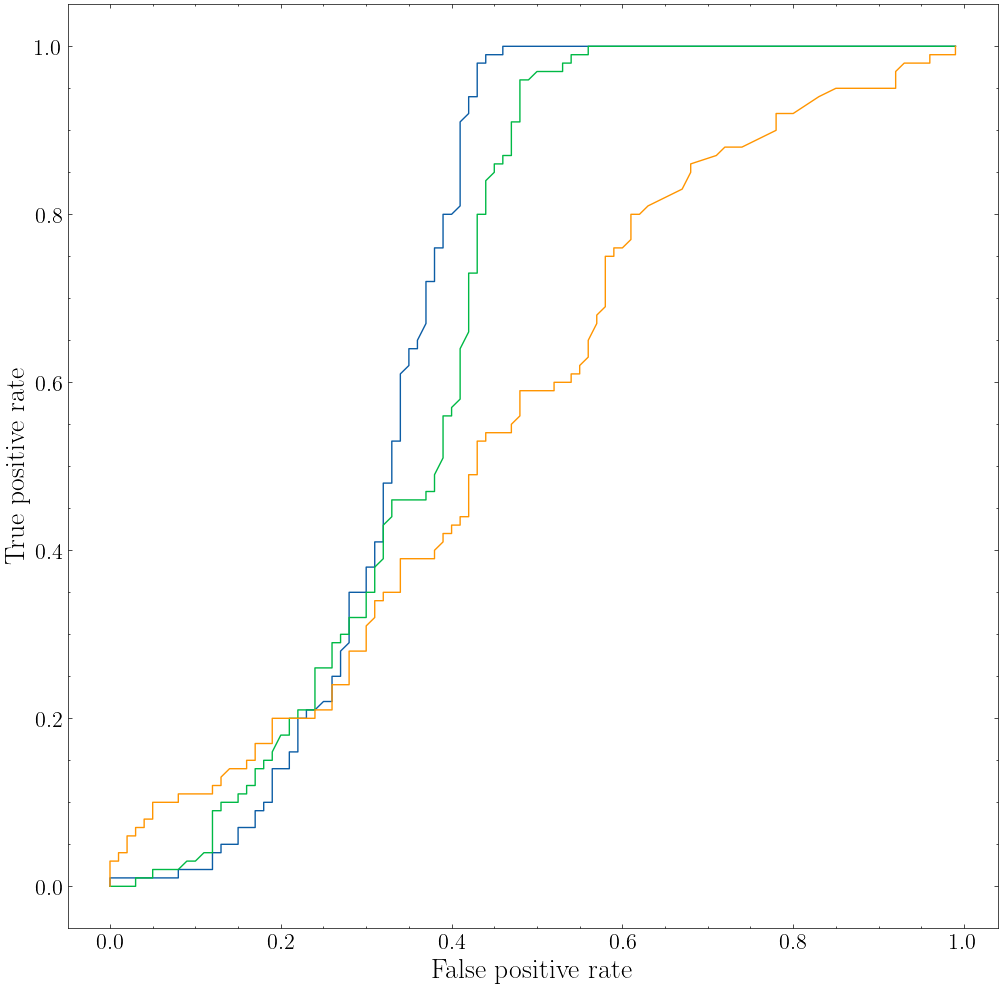

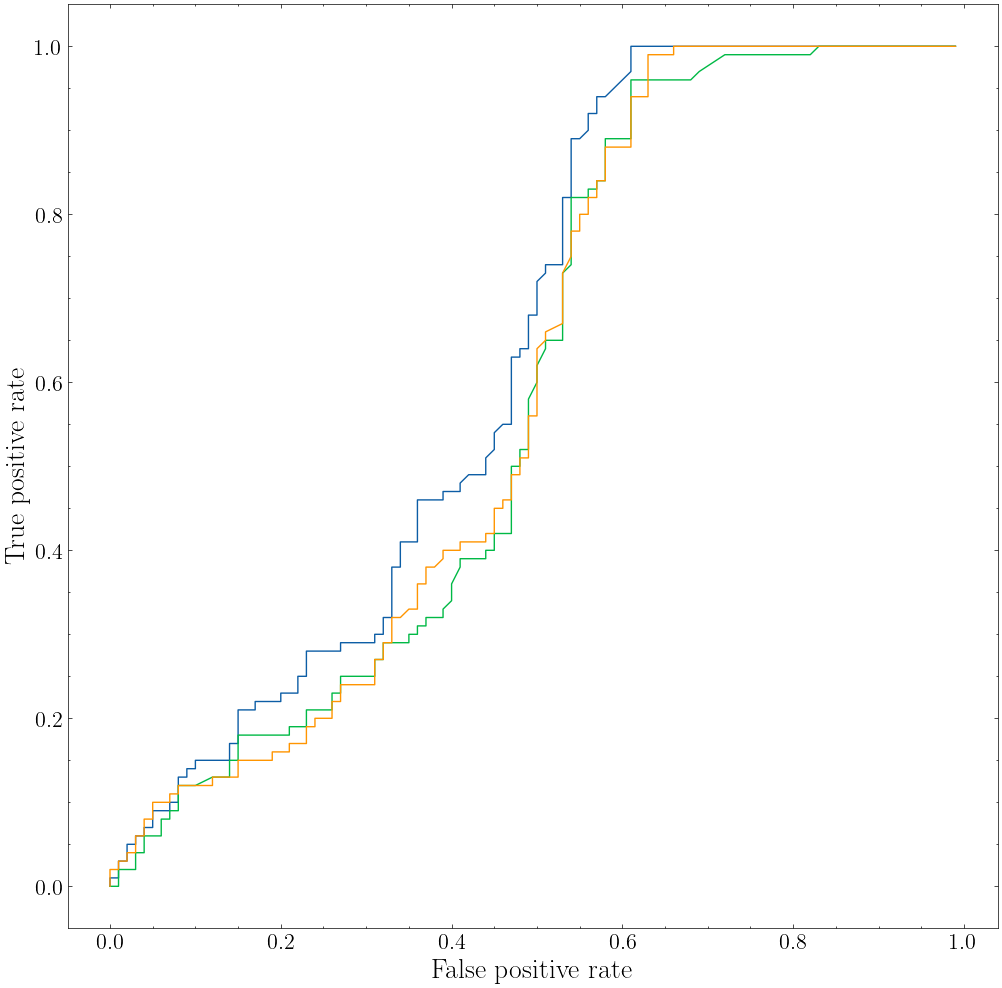

In [89]:
from scipy.io import loadmat
import numpy as np 


from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys

plt.style.use('science')







path1 = "../../data/roc_sec4_1.mat"
path2 = "../../data/roc_sec4_2.mat"

import glob 





def load_and_plot(path,fname=None):


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

    data = loadmat(path)


    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() #shape (1,1001)



    labels = [r'$\gamma = 0.001$', r'$\gamma = 0.01$',r'$\gamma = 0.1$']
    for i in range(len(pd)):
        ax.plot(pfa, pd[i,:], label = labels[i])




    fs = 20
    ax.set_xlabel("False positive rate",fontsize=fs)
    ax.set_ylabel("True positive rate",fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)


   
    if fname is not None:
        plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

    plt.show()
        



    
load_and_plot(path1,fname='example_powerline_roc_curve_1') #this is ∆f = 0.0 with γ = {0.001, 0.01, 0.1} for 1 reference PEM
load_and_plot(path2,fname='example_powerline_roc_curve_2') #thi is γ = 0.02  and ∆f = {0.25, 0.5, 1.0} for 1 reference PEM






# Section 4D



pd_h_002_gammah_0001_df_0_ref_1
pd_h_002_gammah_0001_df_0_ref_2
pd_h_002_gammah_001_df_0_ref_1
pd_h_002_gammah_001_df_0_ref_2
pd_h_002_gammah_001_df_05_ref_1
pd_h_002_gammah_001_df_05_ref_2
-----------------------
pd_h_002_gammah_0001_df_0_ref_1
$\gamma = 10^{-3} \, , \Delta f = 0.0 \, , N_{\rm refs} = 1$ AUC: 0.97545
pd_h_002_gammah_0001_df_0_ref_2
$\gamma = 10^{-3} \, , \Delta f = 0.0 \, , N_{\rm refs} = 2$ AUC: 0.9901499999999999
pd_h_002_gammah_001_df_0_ref_1
$\gamma = 10^{-2} \, , \Delta f = 0.0 \, , N_{\rm refs} = 1$ AUC: 0.8265999999999999
pd_h_002_gammah_001_df_0_ref_2
$\gamma = 10^{-2} \, , \Delta f = 0.0 \, , N_{\rm refs} = 2$ AUC: 0.8221499999999999
pd_h_002_gammah_001_df_05_ref_1
$\gamma = 10^{-2} \, , \Delta f = 0.5 \, , N_{\rm refs} = 1$ AUC: 0.9873000000000001
pd_h_002_gammah_001_df_05_ref_2
$\gamma = 10^{-2} \, , \Delta f = 0.5 \, , N_{\rm refs} = 2$ AUC: 0.9899999999999999
Reference AUC: 0.5450314017192998


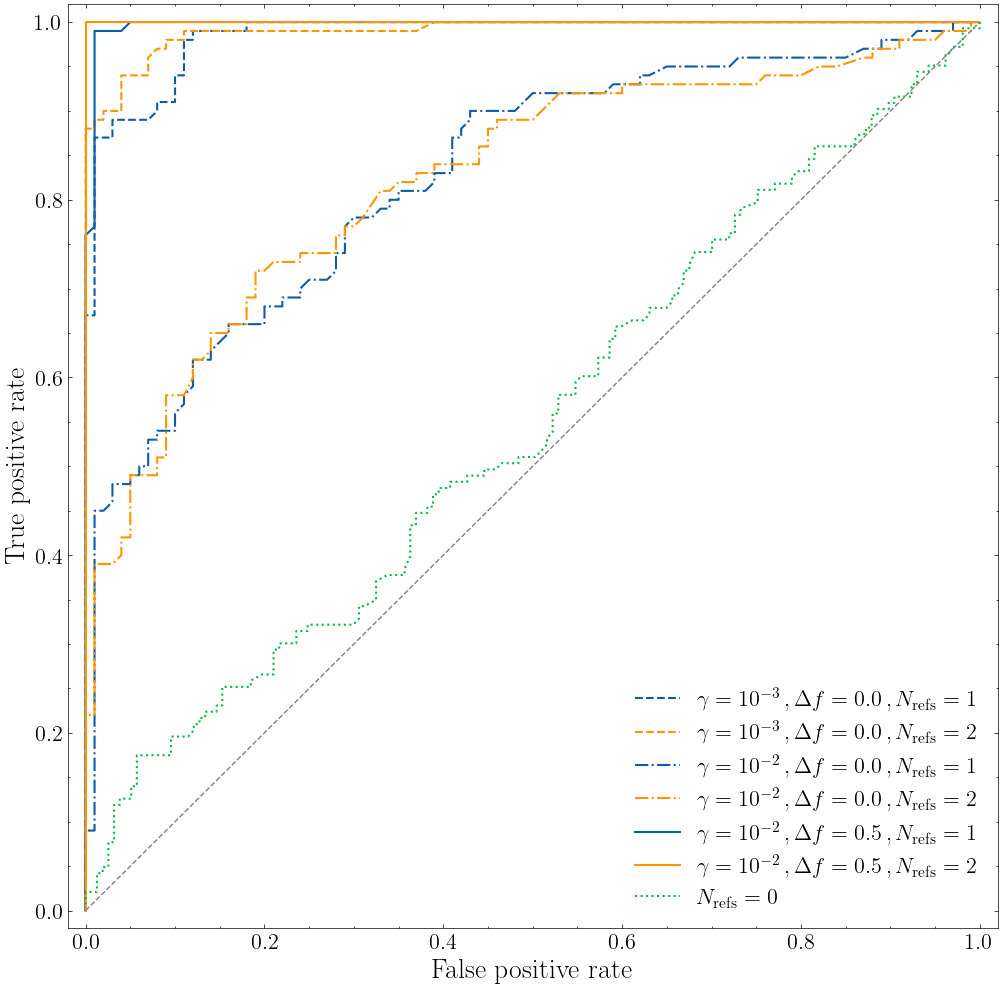

In [230]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob 

plt.style.use('science')
path = "../../data/roc_curves_final.mat"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)




def parse_number_string(fname):
    num_leading_zeros = len(fname.split('1')[0]) - 1 
    val = float(fname) / 10**num_leading_zeros
    return val


def parse_keyname(key):

    row = key.split('_')

    h = row[2]
    gamma = parse_number_string(row[4])
    delta_f = parse_number_string(row[6])
    num_refs = row[-1] #'PEM = 0'
    if num_refs == 'PEM':
        num_refs = 0.0
    num_refs = int(num_refs)
  
    return h,np.log10(gamma)-1,delta_f,num_refs




def load_and_plot(path,ax):


    data = loadmat(path)

    excluded_keys = ['pd_PEM', 'pfa_PEM'] #These are the nothing results i.e. coin toss. e.g. https://app.sparkmailapp.com/web-share/XPIkC9jW8wiCL5Z3Cab9lV562ZIYm1y_PPhc1ZGw
    #excluded_keys = []
    list_of_keys = sorted([k for k in data.keys() if (k.startswith('p') & (k not in excluded_keys)& ~(k.endswith('M')))])
    
    l = len(list_of_keys)

    pd_keys = list_of_keys[0:int(l/2)]
    pfa_keys = list_of_keys[int(l/2):]
    colors = ['C0','C1','C2']
    colors = ['C0','C2']

    linestyles = ['dashed','dashdot','solid']
    color_index = 0
    line_index = 0


    #Some hacky slicing to put df=0.5 at the end
    pd_keys = pd_keys[0:2] + pd_keys[4:6] + pd_keys[2:4]
    pfa_keys = pfa_keys[0:2] + pfa_keys[4:6] + pfa_keys[2:4]

    for kk in pd_keys:
        print(kk)
    print('-----------------------')

    for k in range(len(pd_keys)):
        assert parse_keyname(pd_keys[k]) == parse_keyname(pfa_keys[k])
        h,gamma,delta_f,num_refs = parse_keyname(pd_keys[k])
        print(pd_keys[k])

        #label = [r'$\gamma = 0.001 \, , \Delta f = 0.0 \ , N_{\rm refs} = 0$']

        gamma = int(gamma)
        label = fr'$\gamma = 10^{{{gamma}}} \, , \Delta f = {delta_f} \, , N_{{\rm refs}} = {num_refs}$'

        pfa_key, pd_key = pfa_keys[k], pd_keys[k]

    
        ax.plot(data[pfa_key].flatten(),data[pd_key].flatten(),lw=1.5,label=label,c=colors[color_index],linestyle=linestyles[line_index])

        print(label, 'AUC: {}'.format(auc(data[pfa_key].flatten(),data[pd_key].flatten())))
        
        color_index += 1

        if color_index > 1:
            color_index = 0
            line_index +=1



    
    ax.plot(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten(),lw=1.5,linestyle='dotted',c='C1',label=r'$N_{\rm refs} =0$')
    print('Reference', 'AUC: {}'.format(auc(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten())))


    
load_and_plot(path,ax)




fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)



delta = 0.02
ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)


#ax.set_xscale('log')
#ax.set_xlim(1e-3,1.0)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

fname = '4C_roccurve_multi_ref' 
if fname is not None:
    plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()



Plot just one the diagonal result

pd_h_002_gammah_0001_df_0_NO_PEM
pd_h_002_gammah_0001_df_0_ref_1
pd_h_002_gammah_0001_df_0_ref_2


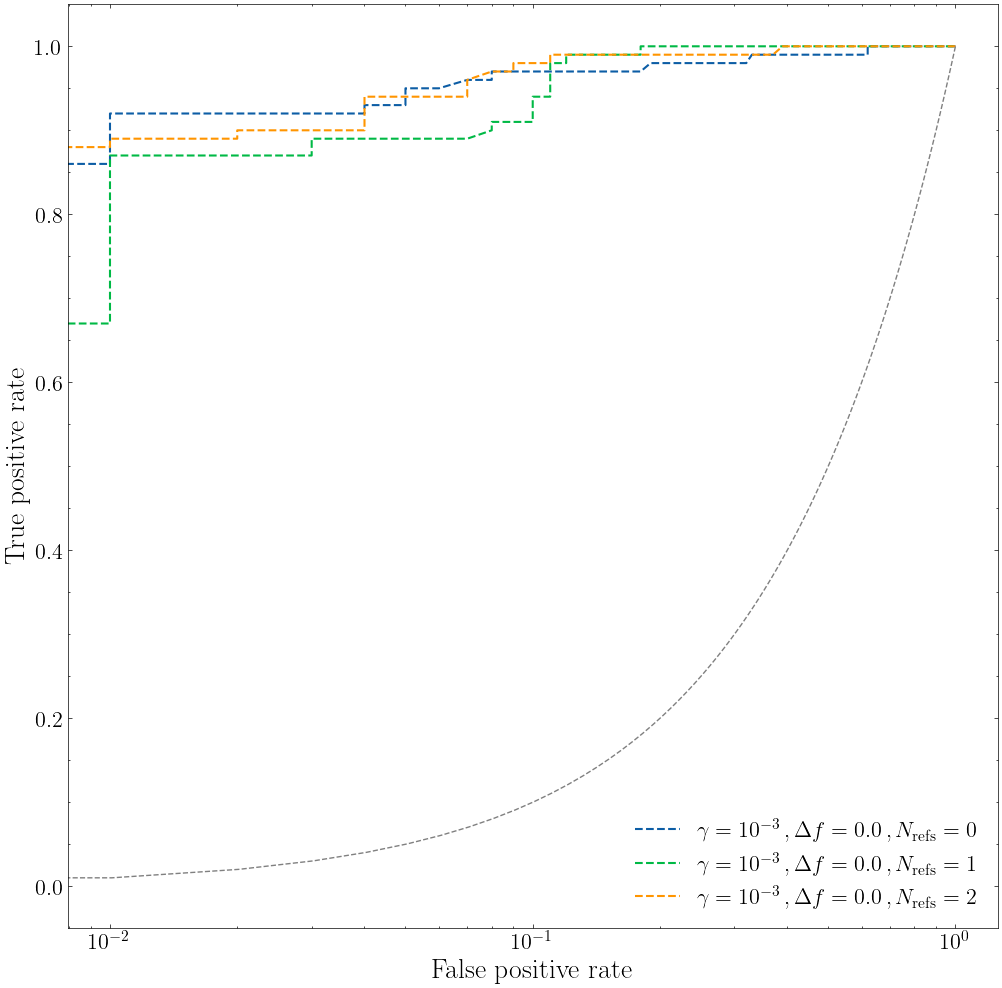

In [198]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob 

plt.style.use('science')
path = "../../data/roc_curves_final.mat"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

            


def parse_number_string(fname):
    num_leading_zeros = len(fname.split('1')[0]) - 1 
    val = float(fname) / 10**num_leading_zeros
    return val


def parse_keyname(key):

    row = key.split('_')

    h = row[2]
    gamma = parse_number_string(row[4])
    delta_f = parse_number_string(row[6])
    num_refs = row[-1] #'PEM = 0'
    if num_refs == 'PEM':
        num_refs = 0.0
    num_refs = int(num_refs)
  
    return h,np.log10(gamma)-1,delta_f,num_refs




def load_and_plot(path,ax):


    data = loadmat(path)

    excluded_keys = ['pd_PEM', 'pfa_PEM'] #These are the nothing results i.e. coin toss. e.g. https://app.sparkmailapp.com/web-share/XPIkC9jW8wiCL5Z3Cab9lV562ZIYm1y_PPhc1ZGw
    list_of_keys = sorted([k for k in data.keys() if (k.startswith('p') & (k not in excluded_keys))])
    
    
     

    
    ax.plot(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten(),lw=1.5,label=label,c=colors[color_index],linestyle=linestyles[line_index])
     


    
load_and_plot(path,ax)




fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)



#delta = 0.05
#ax.set_xlim(0.0-delta,1.0+delta)
#ax.set_ylim(0.0-delta,1.0+delta)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

plt.show()



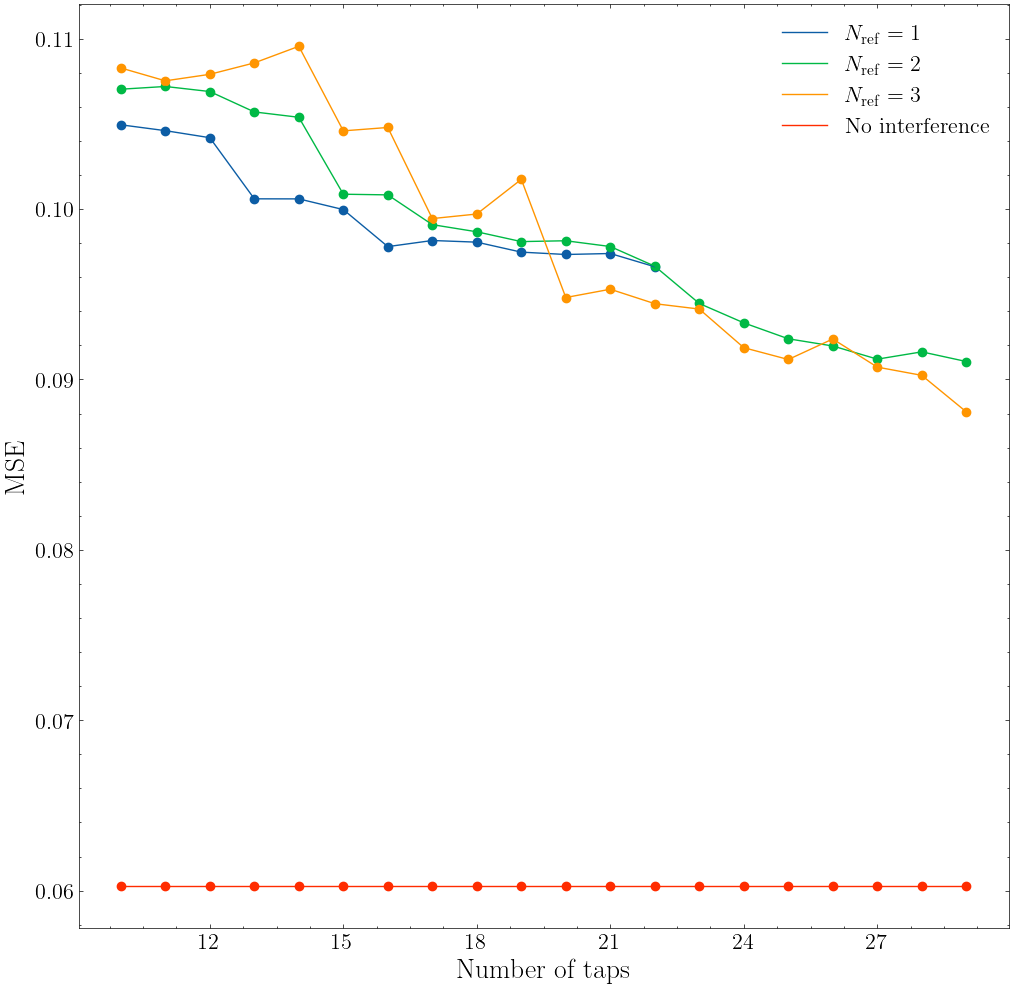

In [242]:
from scipy.io import loadmat
import numpy as np 
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt 

path = "../../data/filter_accuraacy.mat"

data = loadmat(path)
LL = data["LL"]
dw = data["dw"]
gamma = data["gamma"]
gamma_a = data["gamma_a"]
h = data["h"]



#Plot figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

labels = [r'$N_{\rm ref} = 1$', r'$N_{\rm ref} = 2$', r'$N_{\rm ref} = 3$', 'No interference']
for i in range(4):
    y = LL[i,:]
    x = np.arange(len(y))

    ax1.plot(x,y,label=labels[i])
    ax1.scatter(x,y)




fs = 20
ax1.set_ylabel(r'MSE',fontsize=fs)
ax1.set_xlabel(r'Number of taps',fontsize=fs)
ax1.axes.tick_params(axis="both", labelsize=fs-4)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(fontsize=fs-4)
  
fname = "taps_vs_error"
plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()
